In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from pathlib import Path
import pandas as pd
from ydata_profiling import ProfileReport
import warnings

current_dir = os.getcwd()
current_dir

os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

current_dir = os.getcwd()
current_dir

You set a new current directory


'/workspaces/Approval_Predict'

Load collected data

In [2]:
root = current_dir
file_path = Path(root) / "outputs" / "datasets" / "collection" / "loan_approval.csv"

if not file_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {file_path}")

df = pd.read_csv(file_path).drop(['name', 'city'], axis=1)
df.head(5)

,income,credit_score,loan_amount,years_employed,points,loan_approved
0,113810,389,39698,27,50.0,False
1,44592,729,15446,28,55.0,False
2,33278,584,11189,13,45.0,False
3,127196,344,48823,29,50.0,False
4,66048,496,47174,4,25.0,False


Data Exploration

In [3]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

[]

Generate a profiling report for columns with missing data

In [4]:
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

There are no variables with missing data


Add feature of loan to income

In [5]:
df['loan_to_income'] = df['loan_amount'] / df['income']
df.head(3)

,income,credit_score,loan_amount,years_employed,points,loan_approved,loan_to_income
0,113810,389,39698,27,50.0,False,0.348809
1,44592,729,15446,28,55.0,False,0.346385
2,33278,584,11189,13,45.0,False,0.336228


Correlation and PPS Analysis

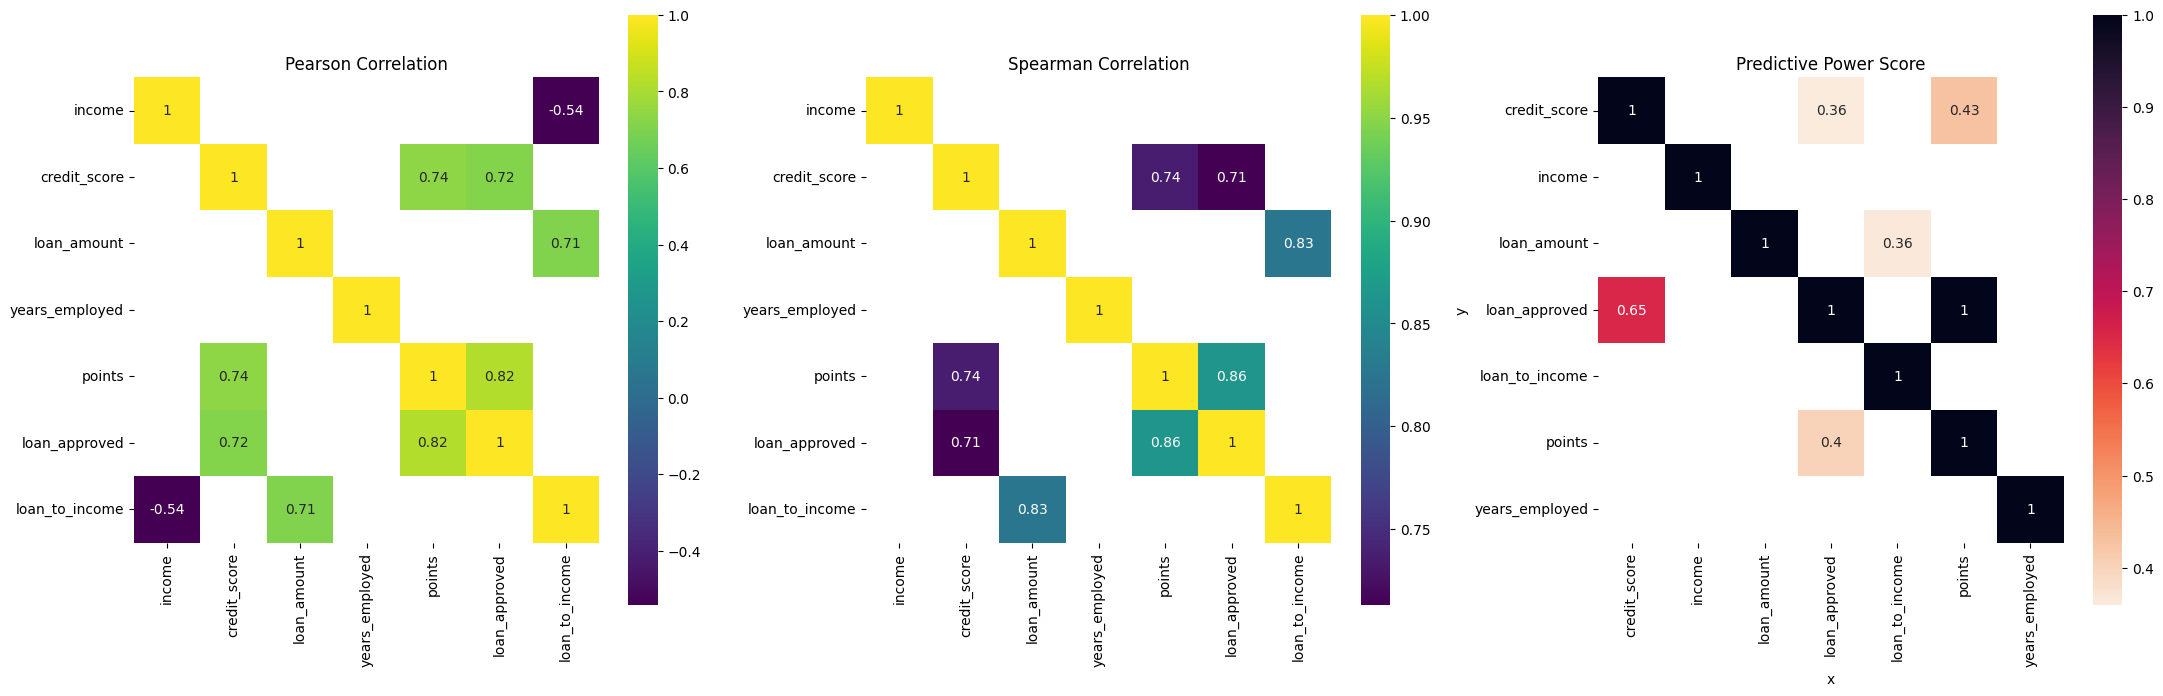

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning, module="ppscore")
warnings.filterwarnings('ignore')


def calculate_corr_and_pps(df):
    pearson = df.corr(method="pearson", numeric_only=True)
    spearman = df.corr(method="spearman", numeric_only=True)

    pps_matrix = pps.matrix(df).pivot(index='y', columns='x', values='ppscore')

    return pearson, spearman, pps_matrix


def plot_all_heatmaps(pearson, spearman, pps_matrix,
                      corr_thresh=0.4, pps_thresh=0.3,
                      figsize=(22,7), annot_size=10):

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Pearson
    sns.heatmap(pearson.where(abs(pearson) >= corr_thresh),
                annot=True, cmap="viridis",
                square=True,
                annot_kws={"size": annot_size},
                ax=axes[0])
    axes[0].set_title("Pearson Correlation")

    # Spearman
    sns.heatmap(spearman.where(abs(spearman) >= corr_thresh),
                annot=True, cmap="viridis",
                square=True,
                annot_kws={"size": annot_size},
                ax=axes[1])
    axes[1].set_title("Spearman Correlation")

    # PPS (asymmetric)
    sns.heatmap(pps_matrix.where(pps_matrix >= pps_thresh),
                annot=True, cmap="rocket_r",
                square=True,
                annot_kws={"size": annot_size},
                ax=axes[2])
    axes[2].set_title("Predictive Power Score")

    plt.tight_layout()
    plt.show()

pearson, spearman, pps_matrix = calculate_corr_and_pps(df)
plot_all_heatmaps(pearson, spearman, pps_matrix,
                  corr_thresh=0.5, pps_thresh=0.3,
                  figsize=(22,7), annot_size=10)


From the heat maps above:

Points have the strongest relationship with loan_approved and indicates points directly influence approval decisions.

Credit score also strongly related to loan approval, thus a high credit score strongly improves approval chances.

Conclusion: Loan approval decisions are primarily driven by applicant financial credibility, not affordability alone.
Credit_score and points capture most of the approval rule logic.

In [9]:
display(pps_matrix.describe())

x,credit_score,income,loan_amount,loan_approved,loan_to_income,points,years_employed
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.276429,0.160143,0.174714,0.258714,0.214571,0.417143,0.144857
std,0.402294,0.373077,0.368296,0.370420,0.371564,0.418325,0.377119
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.031000,0.000000
25%,0.000000,0.000000,0.000000,0.007500,0.000000,0.120000,0.000000
50%,0.000000,0.000000,0.000000,0.035000,0.000000,0.220000,0.000000
75%,0.467500,0.060500,0.111500,0.380500,0.251000,0.714500,0.007000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The index of the taregt variable was renamed to make it more user friendly.

In [16]:
print(y.value_counts(normalize=True).rename({0: "not approved", 1: "approved"}).round(3))



loan_approved
not approved    0.56
approved        0.44
Name: proportion, dtype: float64


## Split Train and Test Set

In [31]:

from sklearn.model_selection import train_test_split

X = df.drop('loan_approved', axis=1)
y = df['loan_approved']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size=0.2,
                                        random_state=42)

print(f"X_train shape: {X_train.shape} \nX_test shape: {X_test.shape}")

X_train shape: (1600, 6) 
X_test shape: (400, 6)


## Push files to Repo

In [32]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

In [33]:
X_train.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

In [34]:
X_test.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)